<h3 style="color: #7aa2f7; font-weight: bold;" align="center">Model Test 00</h3>


<h4 style="color: #7aa2f7;">Why choose to export model in onnx format?</h4>

onnxruntime is an open-source runtime engine for executing machine learning models that are represented in the Open Neural Network Exchange (ONNX) format. ONNX is an open standard for representing deep learning models that allows for interoperability between different frameworks and tools. ONNX models can be exported from a variety of deep learning frameworks, such as PyTorch, TensorFlow, and Keras, and can be executed on different hardware platforms, such as CPUs, GPUs, and FPGAs

In [1]:
import onnxruntime as ort
import numpy as np
import cv2
from PIL import Image

from matplotlib import pyplot as plt

In [2]:
# parameters

MODEL = "../models/model.onnx"
IMAGE = './frame1.jpg'

# TODO(Adam-Al-Rahman): Implement a function to read classes from remx.prototxt
PROTOTXT = 'remx.prototxt'


In [3]:
ort_session = ort.InferenceSession(MODEL)

model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape
input_shape

[1, 3, 640, 640]

In [4]:
model_output = ort_session.get_outputs()
output_names = [model_output[i].name for i in range(len(model_output))]
output_names

['output0']

<h3 style="color: #7aa2f7; font-weight: bold;" align="center">Preprocess Image</h3>

In [5]:
import sys
sys.path.append("../remx/utils")

from images import letterbox, ImgSize, inverse_letterbox_coordinate_transform

img = cv2.imread(IMAGE) # original image

# Converting original image into 640x640 size without losing its aspect ratio
img_letterboxed = letterbox(np.asarray(img), ImgSize(640, 640))


# TODO(Adam-Al-Rahman): Convert any image format to jpg
# Convert the np.ndarray to a byte stream
img_bytes = cv2.imencode('.jpg', img_letterboxed)[1].tobytes()

In [6]:
# read the image from the byte stream
image = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_UNCHANGED)

image_height, image_width = image.shape[:2]

Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
input_height, input_width = input_shape[2:]

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized = cv2.resize(image_rgb, (input_width, input_height))

# Scale input pixel value to 0 to 1
input_image = resized / 255.0
input_image = input_image.transpose(2,0,1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)
input_tensor.shape

(1, 3, 640, 640)


<h3 style="color: #7aa2f7; font-weight: bold;" align="center">Model</h3>

In [7]:

# store the model output
outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0]

In [8]:
# Threshold
predictions = np.squeeze(outputs).T
conf_thresold = 0.85 # confidence score [testing phase]

# Filter out object confidence scores below threshold
scores = np.max(predictions[:, 4:], axis=1)
predictions = predictions[scores > conf_thresold, :]
scores = scores[scores > conf_thresold]

In [9]:
# Get the class with the highest confidence
class_ids = np.argmax(predictions[:, 4:], axis=1)
class_ids

array([0, 0])

In [10]:
# Get bounding boxes for each object
boxes = predictions[:, :4]

#rescale box
input_shape = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, input_shape, dtype=np.float32)
boxes *= np.array([image_width, image_height, image_width, image_height])
boxes = boxes.astype(np.int32)
boxes

array([[189, 282, 217, 160],
       [188, 282, 216, 159]], dtype=int32)

In [11]:
# TODO(Adam-Al-Rahman): Optimize the compute_iou function
def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou

In [12]:

# TODO(Adam-Al-Rahman): Optimize the nms function
def nms(boxes, scores, iou_threshold):
    """
    Non-maximum suppression (NMS)
    Select best bounding box out of a set of overlapping boxes.
    """

    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes

In [13]:
# Apply non-maxima suppression to suppress weak, overlapping bounding boxes
indices = nms(boxes, scores, 0.3)

In [14]:
def xywh2xyxy(x):
    """
    yolov8 provide bounding box (x, y, w, h).
    Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    """
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

In [15]:
# TODO(Adam-Al-Rahman): Implement the remx.prototxt, and read the class from prototxt
# Define classes
CLASSES = ['axis-deer', 'elephant']

letterboxed_boxes = []
labels = []

image_draw = image.copy()
for (bbox, score, label) in zip(xywh2xyxy(boxes[indices]), scores[indices], class_ids[indices]):
    bbox = bbox.round().astype(np.int32).tolist()
    letterboxed_boxes.append(tuple(bbox))
    labels.append(CLASSES[label])

    print(bbox)
    print(score)
    print(label)
    print("----------")

    cls_id = int(label)
    cls = CLASSES[cls_id]
    box_color = (0, 255, 0)

    cv2.rectangle(image_draw, tuple(bbox[:2]), tuple(bbox[2:]), box_color, 2)
    cv2.putText(image_draw,
        f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1.0,
        color=(0, 0, 0),
        thickness=2)

    # TODO(Adam-Al-Rahman): Check the re-apperance of multiple box for same object @ same location, Optimize the nms function
    # break

[80, 202, 297, 362]
0.928945
0
----------
[80, 202, 296, 361]
0.91599023
0
----------


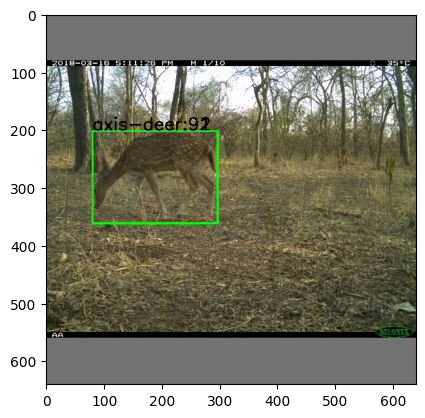

In [16]:

%matplotlib inline

img = cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
plt.imshow(img)
plt.show()


<h3 style="color: #7aa2f7; font-weight: bold;" align="center">Map Letterbox Coordinate to Original Image</h3>

In [17]:
# original image
img = cv2.imread(IMAGE)

inverse_coordinates = inverse_letterbox_coordinate_transform(
    # [(x1, y1, x2, y2)]
    letterboxed_boxes,
    ImgSize(img.shape[1], img.shape[0]),
    ImgSize(640, 640),
)

In [18]:
# BBox coordinate for original image and its label
inverse_coordinates, labels

([(256, 390, 950, 902), (256, 390, 947, 899)], ['axis-deer', 'axis-deer'])

In [19]:
# frame 2
x1, y1, x2, y2 = (115, 374, 742, 886)
w = x2 - x1
h = y2 - y1
ratio = w/h

cx1, cy1 = (x1+x2)/2, (y1+y2)/2
cx1, cy1
ratio

1.224609375

In [20]:
# frame 1
x21, y21, x22, y22 = (256, 390, 950, 902)

w = x22 - x21
h = y22 - y21
ratio = w/h

cx2, cy2 = (x21+x22)/2, (y21+y22)/2
cx2, cy2
ratio

1.35546875

In [21]:
distance = np.sqrt((cx2 - cx1)**2 + (cy2 - cy1)**2)
print(distance)
speed = distance/3 # pixels/sec
speed

175.23198908875057


58.410663029583525

In [22]:
# TODO(Adam-Al-Rahman): Implement the result.csv
# import csv

# with open("../models/results.csv", 'w', newline='') as file:
#   writer = csv.writer(file)


In [23]:

for (bbox, score, label) in zip(inverse_coordinates, scores[indices], class_ids[indices]):
  print(bbox)
  print(score)
  print(label)
  print("----------")

  cls_id = int(label)
  cls = CLASSES[cls_id]
  box_color = (255, 0, 255)

  cv2.rectangle(img, tuple(bbox[:2]), tuple(bbox[2:]), box_color, 10)
  cv2.putText(img,
      f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
      fontScale=3.0,
      color=(0, 0, 0),
      thickness=3)


(256, 390, 950, 902)
0.928945
0
----------
(256, 390, 947, 899)
0.91599023
0
----------


<function matplotlib.pyplot.show(close=None, block=None)>

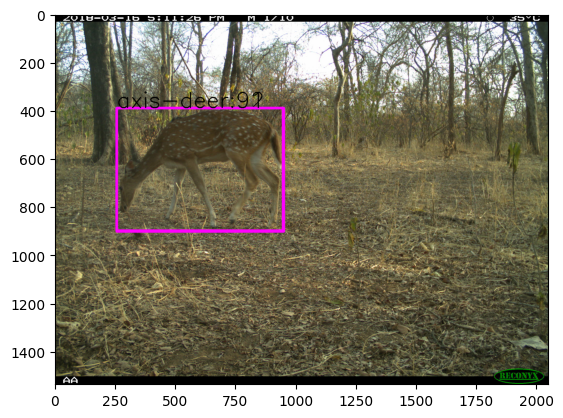

In [24]:
# Display the original image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<h3 style="color: #7aa2f7; font-weight: bold;" align="center">Output</h3>


```python
# BBox coordinate for original image and its label
inverse_coordinates, labels
```

```shell
  (x_min, y_min, x_max, y_max)
([(1684, 1054, 4557, 3098)], ['elephant'])
```

$$
p1 : (round((x_{min} + x_{max})/2), y_{max})  = (3120, 3098) \\
p2 : (round((x_{min} + x_{max})/2), y_{min})  = (3120, 1054)
$$

Our output will be a `csv` file


| Sl. | Image Location | p1 | p2 | Label |
|----|----------------|----|----|-------|
| 1  | "test-elephant.jpg" |(3120, 3098)| (3120, 1054)   | "elephant"|




<h3 style="color: #7aa2f7; font-weight: bold;">Current Issues</h3>

- Multiple boxes for same object​
  - <u>Cause</u>: Maybe [Improper Annotation, Not enough large dataset(Night, Day)]​
- Inference Optimization​
  - <u>Cause</u>: Lack of ONNXRUNTIME library knowledge.​
- Less Epochs​
  - <u>Cause</u>: Not enough GPU memory



<h3 style="color: #7aa2f7; font-weight: bold;">Team Questions</h3>

These are the few questions, which we want to discuss with [Mr. Saurabh Shanu](https://www.linkedin.com/in/saurabh-shanu-3ab715134/?originalSubdomain=in)

1. Which animals should we train the model on?
2. How do the outputs from our model contribute to the Animeter tool?
3. What is our next aim to implement?
4. Why are we considering the distance factor (if necessary)?


<h4 style="color: #7aa2f7;" >Improvement Questions</h4>

1. What areas should be improved? (excluding model accuracy)


<h4 style="color: #7aa2f7;">Need Help With</h4>

- Use of `Animeter`
  - Please explain the 'Animeter' tool using a proper example, and outline our objective after obtaining the model output.